# Diffusion Kernels, Random Walks and Classification
#### Authors: Sean Segal & Ekansh Sharma / CSC 2421H : Graphs, Matrices, and Optimization (Prof. Sushant Sachdeva)

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import time
import scipy
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# Functions for graphs we would like to visualize. We do this since each graph may need to be visualized differently.
def get_complete_graph(n):
    G = nx.complete_graph(n)
    return G, nx.drawing.spring_layout(G)

def get_barbell_graph(n):
    G = nx.barbell_graph(n, 0)
    return G, nx.drawing.spring_layout(G, iterations=100)

def get_2d_graph(n):
    G = nx.grid_2d_graph(n, n)
    layout = {n: np.array([n[0], n[1]]) for n in G.nodes()}
    return G, layout

def get_random_graph(n, p):
    G = nx.fast_gnp_random_graph(n, p)
    return G, nx.drawing.circular_layout(G)

def get_random_regular_graph(n, d):
    G = nx.random_regular_graph(d, n)
    return G, nx.drawing.spring_layout(G)

# Diffusion Kernels 
Let's compute the diffusion kernel for different values of $\beta$. 

Below, we do the following. For some value of $\beta$ (which can be selected with the slider),
1. Compute $K = \exp(-\beta L)$
2. Visualize a row of $K$.

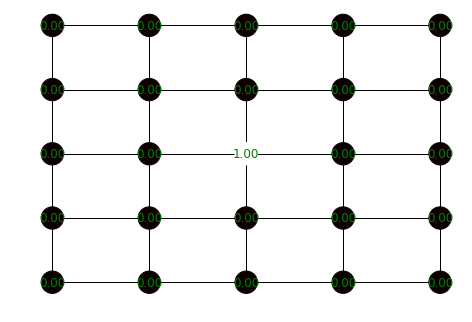

In [3]:
# Diffusion on 2D grid
def visualize_diffusion_on_barbell():
    n = 5
    starting_vertex = 12
    G, layout = get_2d_graph(n)
    lap = nx.laplacian_matrix(G).toarray()
    def visualize_diffusion(beta=0.0):
        kernel = scipy.linalg.expm(-lap*beta)
        labels = {i: "{:0.2f}".format(kernel[starting_vertex, i[0]*n + i[1]]) for i in G.nodes()}
        nx.draw(G, pos=layout, node_size=500, node_color=kernel[starting_vertex, :], cmap='hot', font_color='g', labels=labels, vmin=0.0, vmax=0.10)
        plt.show()

    interact(visualize_diffusion, beta=(0.0, 10.0))

visualize_diffusion_on_barbell()

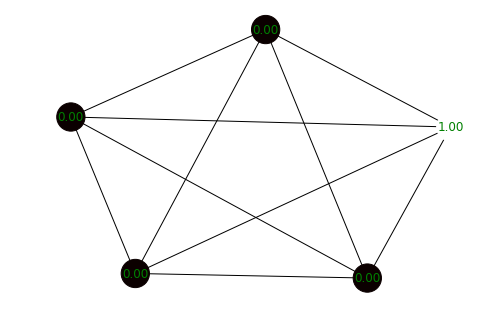

In [4]:
# Diffusion on the complete graph
def visualize_diffusion_on_barbell():
    G, layout = get_complete_graph(5)
    lap = nx.laplacian_matrix(G).toarray()
    starting_vertex = 0 # Vertex where diffusion starts
    def visualize_diffusion(beta=0.0):
        kernel = scipy.linalg.expm(-lap*beta)
        labels = {i: "{:0.2f}".format(kernel[starting_vertex, i]) for i in range(kernel.shape[0])}
        nx.draw(G, pos=layout, node_color=kernel[starting_vertex, :], labels=labels, node_size=800, cmap='hot',font_color='g', vmin=0, vmax=1.0)
        plt.show()

    interact(visualize_diffusion, beta=(0.0, 2.0))

visualize_diffusion_on_barbell()

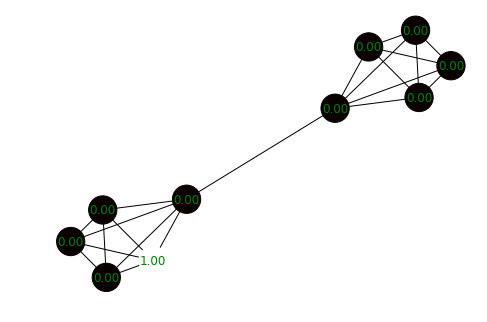

In [12]:
# Diffusion on barbell (dumbbell) graph
def visualize_diffusion_on_barbell():
    G, layout = get_barbell_graph(5)
    lap = nx.laplacian_matrix(G).toarray()
    starting_vertex = 0 # Vertex where diffusion starts
    def visualize_diffusion(beta=0.0):
        kernel = scipy.linalg.expm(-lap*beta)
        labels = {i: "{:0.2f}".format(kernel[starting_vertex, i]) for i in range(kernel.shape[0])}
        nx.draw(G, pos=layout, node_color=kernel[starting_vertex, :], labels=labels, node_size=800, cmap='hot',font_color='g', vmin=0, vmax=0.25)
        plt.show()

    interact(visualize_diffusion, beta=(0.0, 10.0))

visualize_diffusion_on_barbell()

# Relationship to Random Walks

Let's consider a Lazy Random Walk which is slightly different from that which we've seen in class so far. 

Let $0 \leq \beta \leq \max_{i} 1/d_{i}$ be a parameter of the random walk. Given that you are at vertex $v_{i} \in V$ at time $t$, 
- Stay at $v_{i}$ with probability 1 - $\beta d_{i}$ (where $d_{i}$ is the degree of node $i$)
- Otherwise, sample an edge $(v_{i}, v) \in E$ uniformly and transition to $v$


Then we can write the random walk matrix as,
$$ W = (I - \beta D) + \beta A $$

In [6]:

def lazy_random_walk_step(p, G, beta, num_steps=1):
    '''
        Compute the probability distribution after num_steps of the RW defined above.
        :param p initial distribution
        :param G the graph
        :param beta paramter of the RW
        :param delta_t (time step - only matters in continuous setting)
        :param num_steps # of steps to take
        
    '''

    n = len(G.nodes())
    A = nx.adjacency_matrix(G).toarray()
    D = nx.laplacian_matrix(G).toarray() + A
    assert (beta <= 1/np.diag(D)).all() and beta >= 0
    # Lazy Random Walk Matrix
    beta = beta/num_steps
    W = (np.eye(n) - beta*D) + beta*A 
    return np.dot(np.linalg.matrix_power(W, num_steps), p)

def print_one_step_on_complete_graph():
    G, layout = get_complete_graph(5)
    # Initial distribution
    p_0 = np.zeros(len(G.nodes()), dtype=np.float32)
    p_0[0] = 1.0
    print('Initial Distribution (p_0)', p_0)
    p_1 = lazy_random_walk_step(p_0, G, 0.01)
    print('Distribution after one step (p_1)', p_1)

    
print_one_step_on_complete_graph()

Initial Distribution (p_0) [1. 0. 0. 0. 0.]
Distribution after one step (p_1) [0.96 0.01 0.01 0.01 0.01]


# Continuous Time

What happens if we take $s$ steps?
$$\left(I - \beta D + \beta A\right)^{s} $$


What happens if we take $s$ steps, but only transition from one edge to another with probability $\frac{\beta}{s}$? 
$$\left(I - \frac{\beta}{s} D + \frac{\beta}{s} A\right)^{s} $$


What if we take the limit as $s \rightarrow \infty$?
\begin{align}
\lim_{s \rightarrow \infty} \left(I - \frac{\beta}{s} D + \frac{\beta}{s} A\right)^{s}  
&= \lim_{s \rightarrow \infty} \left((I - \frac{\beta}{s} (D - A)\right)^{s}\\
&= \lim_{s \rightarrow \infty} \left(I - \frac{\beta}{s} L\right)^{s}\\
&= \exp(- \beta L)\\
\end{align}




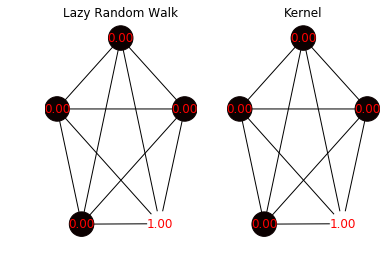

In [7]:
def visualize_random_walk():
    G, layout = get_complete_graph(5)
    lap = nx.laplacian_matrix(G).toarray()
    def visualize(beta=0.0, steps=1):
        p = np.zeros(len(G.nodes()), dtype=np.float32)
        p[0] = 1.0
        delta_t = 1/steps
        p = lazy_random_walk_step(p, G, beta, steps)
        kernel = scipy.linalg.expm(-lap*beta)
        labels = {i: "{:.2f}".format(p[i]) for i in range(len(G.nodes()))}
        plt.subplot(121)
        plt.title('Lazy Random Walk')
        nx.draw(G, pos=layout, node_color=p, cmap='hot', labels=labels, font_color='r', node_size=600, vmin=0, vmax=1.0)
        plt.subplot(122)
        plt.title('Kernel')
        labels = {i: "{:.2f}".format(kernel[0, i]) for i in range(len(G.nodes()))}
        nx.draw(G, pos=layout, node_color=kernel[0, :], cmap='hot', labels=labels, node_size=600, font_color='r', vmin=0, vmax=1.0)
        plt.show()
    interact(visualize, steps=(1, 10000), beta=(0.0, 0.25, 0.001))

visualize_random_walk()

# Classification on Graphs

### Dataset

Imagine we have a graph $G = (V,E)$ and some labeled data for a subset of vertices $S = \left\{(v, l_v) \right\}_{v\in V'}$ where $l_v \in \{-1, 1\}$. We want to classify the nodes that are not in our dataset.

### Simple Classification Algorithm 
Here is a simple classification algorithm (Aside: we could improve this algorithm by using a more complicated technique like SVMs)
1. Given $G = (V,E)$ and $\beta$, compute the matrix $K_{\beta}$.
1. To classify a new node $u \in V$, compute the score $s(u)$, 
$$ s(u) = \sum_{(v, l_v) \in S} l_v * K(u, v)$$
1. If $s(u) > 0$, predict $1$ else predict $-1$

### Interpretation

Start a *diffusion* at each labeled node. If the node is labeled positively, start a diffusion with postive heat. If the node is labeled negatively, start the diffusion with "negative" heat. Choose $\beta$ to determine how long to run the diffusion. For all other nodes, predict +1 if the resulting heat at the node is positive, otherwise predict -1.


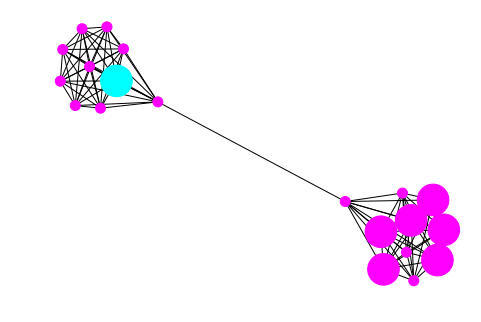

In [8]:
# Classification on dumbbell graph

def classification_on_dumbbell():
    n,p = 20, 0.2
    G, layout = get_barbell_graph(10)
    lap = nx.laplacian_matrix(G).toarray()
    labels = np.zeros(n)
    labels[[0,1, 2, 3, 4, 5]] = 1
    labels[[18]]= -1

    def compute_scores(K):
        return np.sum(np.expand_dims(labels, 1)*K[:, :], axis=0)

    def visualize_classification(beta):
        kernel = scipy.linalg.expm(-lap*beta)
        predictions = 2*(compute_scores(kernel) > 0) - 1

        # We know these values from the GT
        predictions = (labels != 0)*labels + (labels ==0)*predictions

        # Draw the Ground Truth larger than other nodes
        sizes = [1000 if labels[i] != 0 else 100 for i in range(n)]
        nx.draw(G, pos=layout, node_color=predictions, node_size=sizes, cmap='cool', vmin=-1.0, vmax=1.0)
        plt.show()

    interact(visualize_classification, beta=(0.001, 10, 0.001))

classification_on_dumbbell()

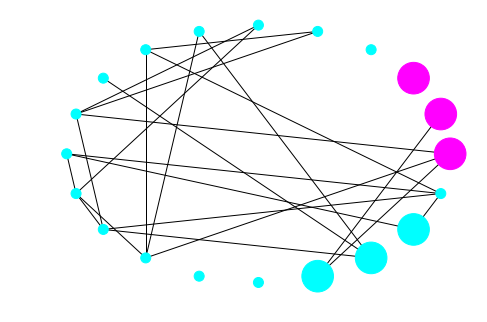

In [9]:
# Classification on random graph
def classification_on_random_graph():
    n,p = 20, 0.1
    G, layout = get_random_graph(n, p)
    lap = nx.laplacian_matrix(G).toarray()
    labels = np.zeros(n)
    labels[[0,1, 2]] = 1
    labels[[18, 17, 16]]= -1

    def compute_scores(K):
        return np.sum(np.expand_dims(labels, 1)*K[:, :], axis=0)

    def visualize_classification(beta):
        kernel = scipy.linalg.expm(-lap*beta)
        predictions = 2*(compute_scores(kernel) > 0) - 1

        # We know these values from the GT
        predictions = (labels != 0)*labels + (labels ==0)*predictions

        # Draw the Ground Truth larger than other nodes
        sizes = [1000 if labels[i] != 0 else 100 for i in range(n)]
        nx.draw(G, pos=layout, node_color=predictions, node_size=sizes, cmap='cool', vmin=-1.0, vmax=1.0)
        plt.show()

    interact(visualize_classification, beta=(0.001, 10, 0.001))

classification_on_random_graph()

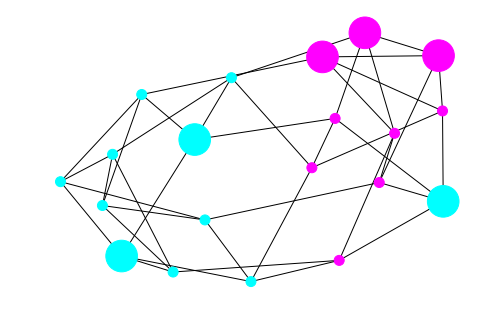

In [10]:
# Classification on random regular graph

def classification_on_random_regular_graph():
    n,d  = 20, 4
    G, layout = get_random_regular_graph(n, d)
    lap = nx.laplacian_matrix(G).toarray()
    labels = np.zeros(n)
    labels[[0,1, 2]] = 1
    labels[[18, 17, 16]]= -1

    def compute_scores(K):
        return np.sum(np.expand_dims(labels, 1)*K[:, :], axis=0)

    def visualize_classification(beta):
        kernel = scipy.linalg.expm(-lap*beta)
        predictions = 2*(compute_scores(kernel) > 0) - 1

        # We know these values from the GT
        predictions = (labels != 0)*labels + (labels ==0)*predictions

        # Draw the Ground Truth larger than other nodes
        sizes = [1000 if labels[i] != 0 else 100 for i in range(n)]
        nx.draw(G, pos=layout, node_color=predictions, node_size=sizes, cmap='cool', vmin=-1.0, vmax=1.0)
        plt.show()

    interact(visualize_classification, beta=(0.001, 10, 0.001))

classification_on_random_regular_graph()